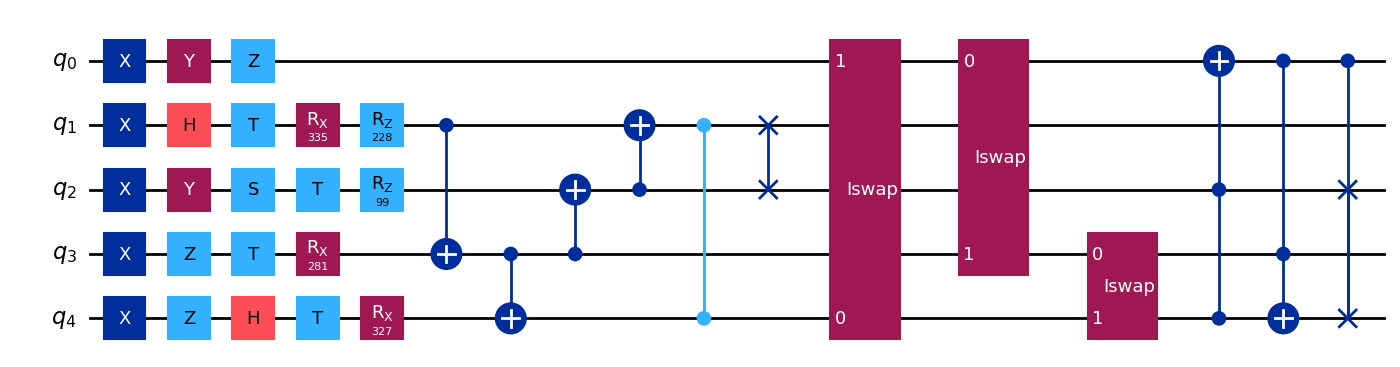

In [281]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import random
import math

def apply_single_gate(gate, n_qubits: int, conditions: list[int]):
    for i in range(n_qubits):
        if conditions[i] == 1:        
            gate(i)
        elif conditions[i] == 0:
            pass

def apply_r_gate(gate, n_qubits: int, conditions: list[int], rotations: list):
    for i in range(n_qubits):
        if conditions[i] == 1:        
            gate(rotations[i], i)
        elif conditions[i] == 0:
            pass

def apply_two_qubit_gate(gate, n_qubits: int, conditions: list[int], qubits_to_apply: list[list[int]]):
    for i in range(n_qubits):
        if conditions[i] == 1:
            gate(qubits_to_apply[i][0], qubits_to_apply[i][1])
        elif conditions[i] == 0:
            pass

def apply_three_qubit_gate(gate, n_qubits: int, conditions: list[int], qubits_to_apply: list[list[int]]):
    for i in range(n_qubits):
        if conditions[i] == 1:
            gate(qubits_to_apply[i][0], qubits_to_apply[i][1], qubits_to_apply[i][2])
        elif conditions[i] == 0:
            pass

def randlist(a, b, n):
    return [random.randint(a,b) for i in range(n)]
def generate_distinct_qubit_set(qubits: int, n: int) -> tuple[int]:
    qubits_list = [random.randint(0, qubits - 1)]
    if n > qubits:
        raise ValueError("You must generate less or the same number of qubits as the maximum amount.")
    else:
        pass
    for i in range(n-1):
        while True:
            qubit_n = random.randint(0, qubits - 1)
            if qubit_n in qubits_list:
                continue
            elif qubit_n not in qubits_list:
                qubits_list.append(qubit_n)
                break
    return qubits_list
        
def create_qc(n: int):
    gates_to_apply = ["x", "y", "z", "h", "s", "t", "rx", "ry", "rz", "cx", "cz", "swap", "iswap", "ccx", "cswap"]
    qc = QuantumCircuit(n)
    for i in gates_to_apply:
        match i:
            case "x":
                apply_single_gate(qc.x, n, randlist(0, 1, n))
            case "y":
                apply_single_gate(qc.y, n, randlist(0, 1, n))
            case "z":
                apply_single_gate(qc.z, n, randlist(0, 1, n))
            case "h":
                apply_single_gate(qc.h, n, randlist(0, 1, n))
            case "s":
                apply_single_gate(qc.s, n, randlist(0, 1, n))
            case "t":
                apply_single_gate(qc.t, n, randlist(0, 1, n))
            case "rx":
                apply_r_gate(qc.rx, n, randlist(0, 1, n), randlist(0, 360, n))
            case "ry":
                apply_r_gate(qc.ry, n, randlist(0, 1, n), randlist(0, 360, n))
            case "rz":
                apply_r_gate(qc.rz, n, randlist(0, 1, n), randlist(0, 360, n))
            case "cx":
                apply_two_qubit_gate(qc.cx, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 2) for i in range(n)])
            case "cz":
                apply_two_qubit_gate(qc.cz, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 2) for i in range(n)])
            case "swap":
                apply_two_qubit_gate(qc.swap, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 2) for i in range(n)])
            case "iswap":
                apply_two_qubit_gate(qc.iswap, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 2) for i in range(n)])
            case "ccx":
                apply_three_qubit_gate(qc.ccx, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 3) for i in range(n)])
            case "cswap":
                apply_three_qubit_gate(qc.cswap, n, randlist(0, 1, n), [generate_distinct_qubit_set(n, 3) for i in range(n)])
                
    return qc

# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc = create_qc(5)
qc.draw("mpl")

In [282]:
# Set up six different observables.
observables_list = ["I", "I", "I", "I", "I", "I", "X", "X", "X", "X", "X", "X", "Y", "Y", "Y", "Y", "Y", "Y", "Z", "Z", "Z", "Z", "Z", "Z"] 
observables_labels = [condense_list(random.choices(observables_list, k = n_qubits)) for i in range(30)]
observables = [SparsePauliOp(label) for label in observables_labels]

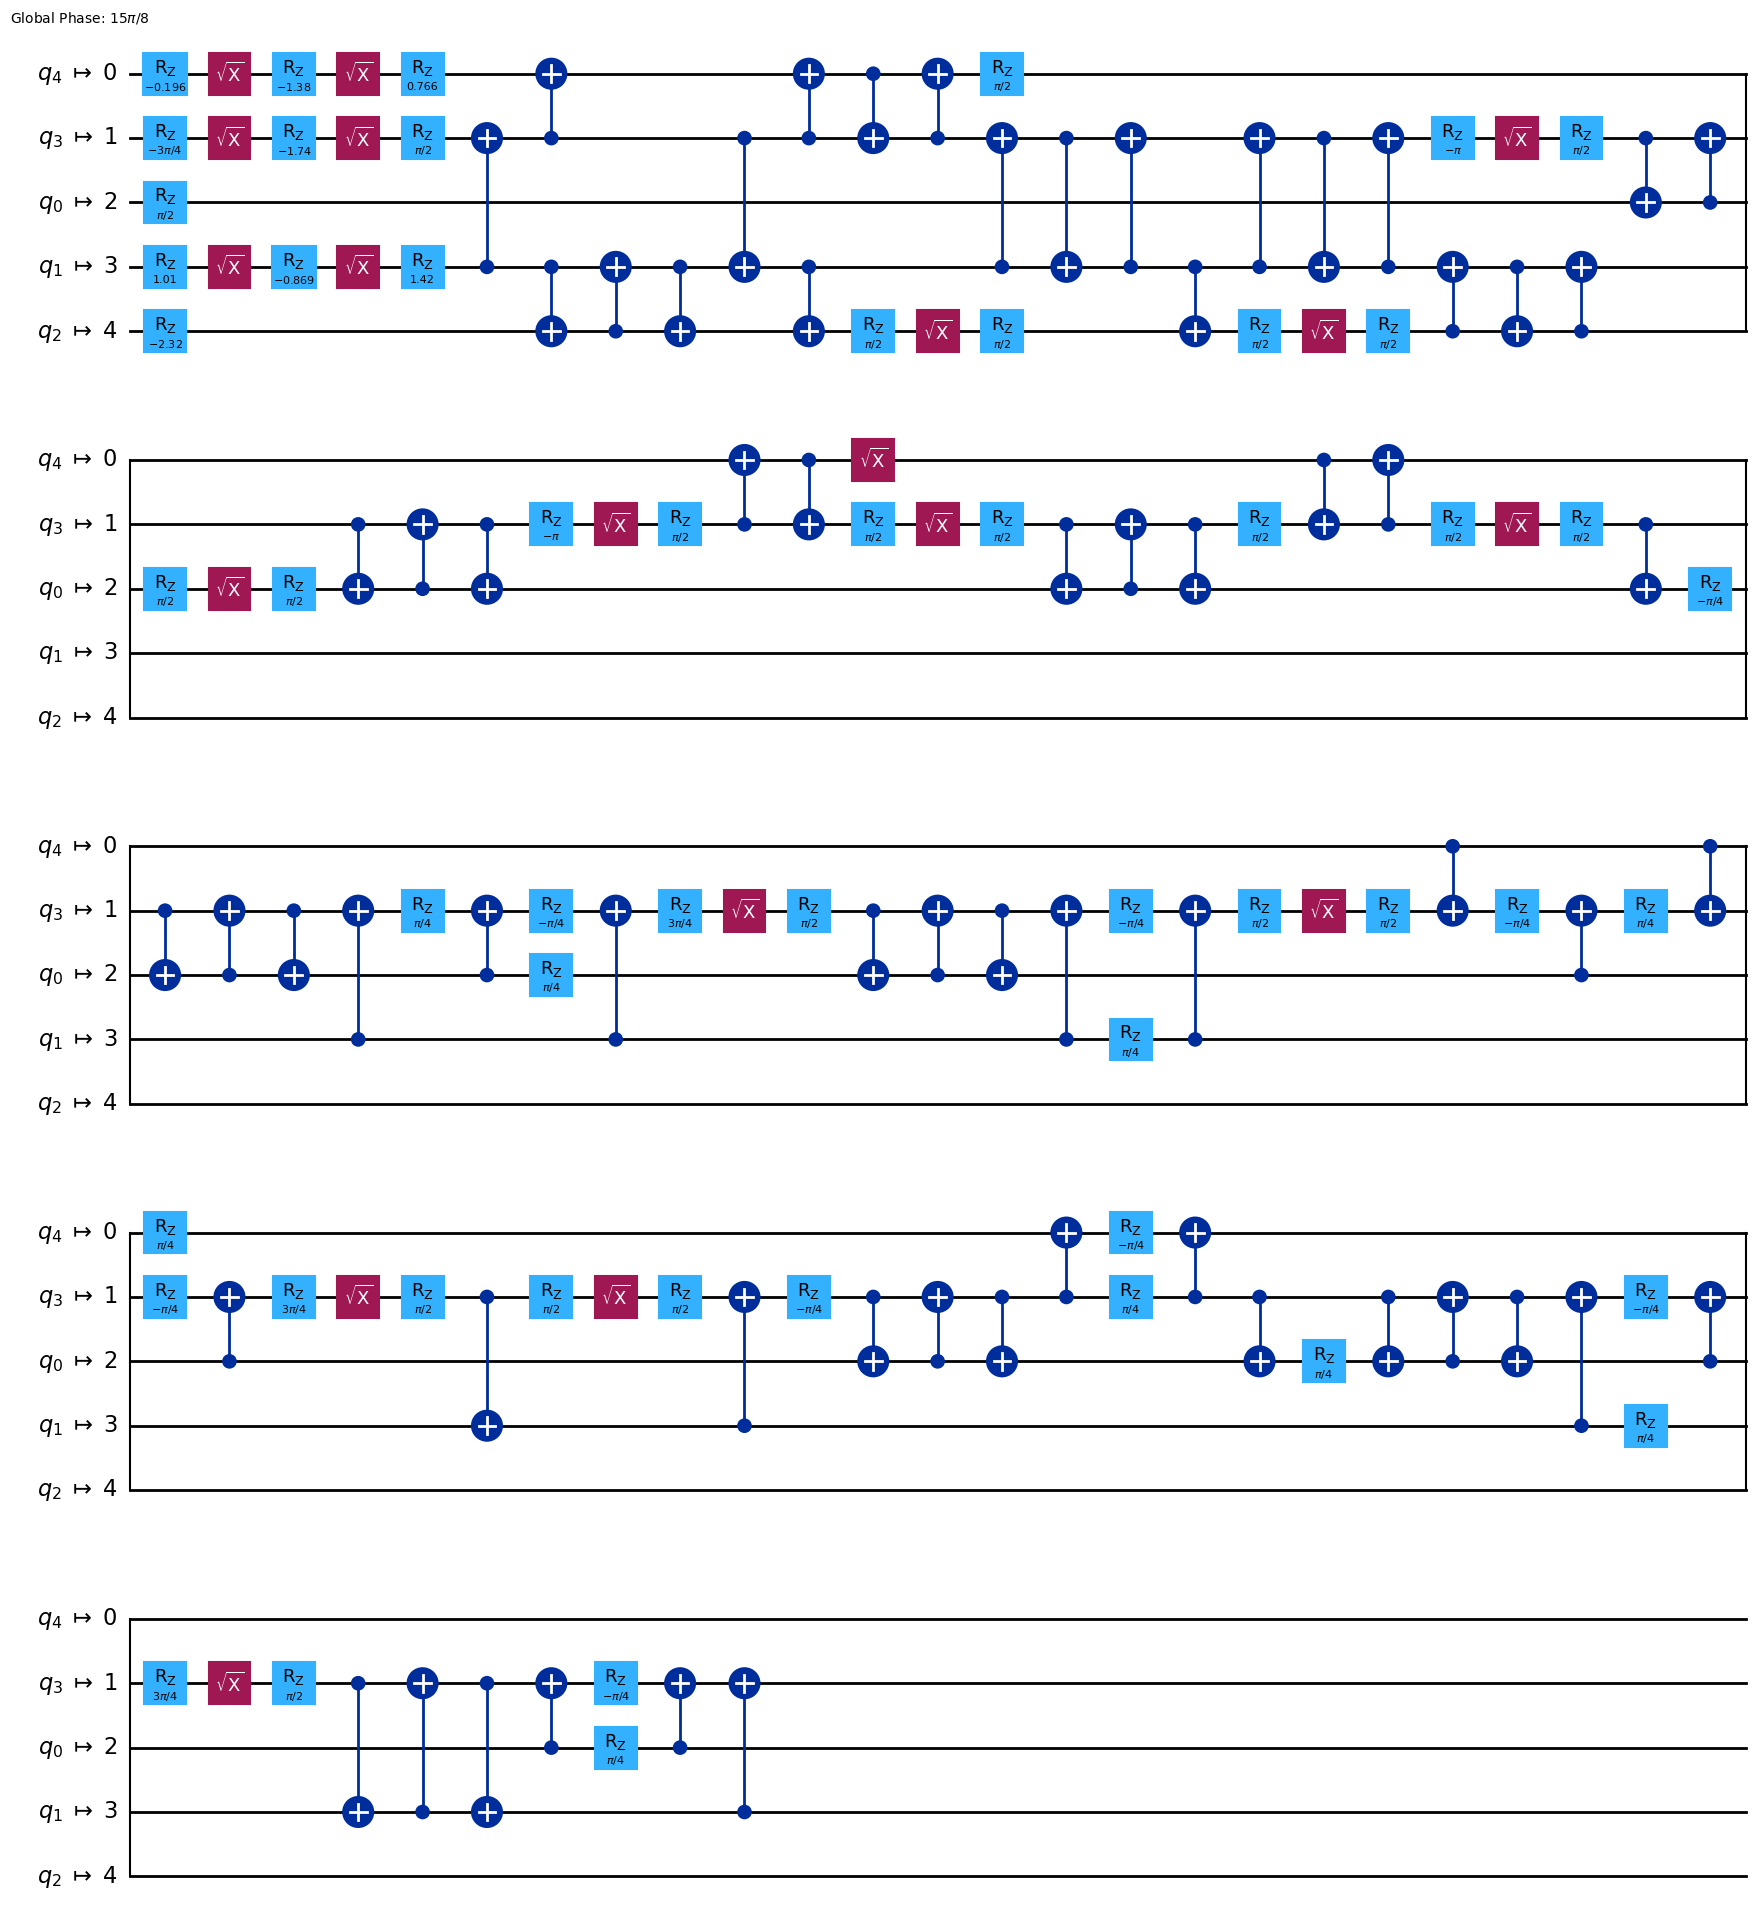

In [283]:
from qiskit_ibm_runtime.fake_provider import FakeBelemV2
 
backend = FakeBelemV2()
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

In [284]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
#estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: 11b00b7b-a201-4c90-93f5-bf1cbca09e40


In [285]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [286]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs.tolist()
 
errors = pub_result.data.stds.tolist()
 
# plotting graph
#plt.plot(observables_labels, values, "-o")
#plt.xlabel("Observables")
#plt.ylabel("Values")
#plt.show()

# Printing the values and errors
print(values)
print(errors)

[0.01, 0.1132, 0.0012, 0.7832, -0.0084, 0.0032, -0.0096, 0.3936, -0.0004, -0.2196, -0.298, -0.0228, -0.0972, -0.002, 0.1324, 0.0164, 0.0064, -0.0084, 0.008, 0.0084, -0.0108, 0.0092, 0.0204, -0.1896, 0.012, 0.2372, -0.0104, 0.2732, -0.314, -0.0116]
[0.01414142849927121, 0.014051233113147045, 0.014142125441389635, 0.008793153700464925, 0.01414163668038463, 0.014142063215811192, 0.01414148393910625, 0.013000607985782819, 0.014142134492360054, 0.013796926034446948, 0.013499599994073897, 0.01413845932200535, 0.014075170762729666, 0.014142107339431418, 0.014017633466459309, 0.014140233661435726, 0.014141845989827494, 0.01414163668038463, 0.014141683068149986, 0.01414163668038463, 0.014141310830329696, 0.014141537115886659, 0.014139192621928594, 0.013885617307127543, 0.014141117353306986, 0.013738530925830461, 0.014141370796354927, 0.013604129961155178, 0.013426868585042455, 0.014141184108836146]


In [287]:
print(((math.fsum(values)/len(values)) * math.fsum(errors)) * 1000)

11.40353946540107
